# Analyze Output of Ped Sim
(Assume Ped Sim Output is in parallel folder to the hapsburg git folder

In [2]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt

### Do the Arial 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Harald's new laptop detected!")
    path = "/home/hringbauer/git/HAPSBURG/" 
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/")  # Go to the hapsburg package directory

from hapsburg.PackagesSupport.pp_individual_roh_csvs import post_process_roh_df, combine_ROH_df
from hapsburg.figures.plot_bars import plot_panel_row, prepare_dfs_plot, create_cousins_roh

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Code to run pedsim
Run in shell:  
`./ped-sim -d example/roh_1st_cousin.def -m refined_mf.simmap -o output/c1 --intf interfere/nu_p_campbell.tsv`  
`./ped-sim -d example/roh_2nd_cousin.def -m refined_mf.simmap -o output/c2 --intf interfere/nu_p_campbell.tsv`  

etc. for: 3rd_cousin, 4th_cousin, 5th_cousin
`./ped-sim -d example/roh_full_sib.def -m refined_mf.simmap -o output/c0 --intf interfere/nu_p_campbell.tsv`

### Funtion to load and process data

In [3]:
def load_segment_file(path_segments="../ped-sim/output/output.seg",
                      roh_only=False, cm_fac=0.01):
    """Load and return segment File of IBD & ROH blocks.
    Return Pandas dataframe. 
    roh_only: Only load ROH blocks
    cm_fac: Factor with which to multiply genetic length columns"""
    df = pd.read_csv(path_segments, sep="\t", header=None)
    df.columns = ["iid1", "iid2", "ch", "Start", "End", 
                  "ibd_stat", "StartM", "EndM", "lengthM"]
    df["length"] = (df["End"] - df["Start"])
    
    for col in ["StartM", "EndM", "lengthM"]:
        df[col] = df[col] * cm_fac
        
    if roh_only:
        df = extract_roh_df(df)
    return df

def extract_roh_df(df, col="ibd_stat", stat="HBD"):
    """Extract and return Dataframe of ROH segments 
    in hapsburg format"""
    df = df[df[col]==stat]
    df = df.drop(columns="iid2")
    df = df.rename(columns={"iid1": "iid"})
    return df

def to_hapsburg_df(path_segments = "../ped-sim/output/test.seg", clst="1st_cousin",
                   savepath = "", n=500,
                   min_cm=[4, 8, 12, 20], snp_cm=100,
                   gap=0.5, min_len1=2, min_len2=4,
                   output=False, sort=True):
    """Load pd_sim output and post_process into Hapsburg
    Summary output. Return this dataframe.
    If savepath is given, save to there (tab-seperated)"""
    df1 = load_segment_file(path_segments, roh_only=True)  # Load the full segment file, transfomred

    ### Split up into lists of Dataframes
    grouped = df1.groupby(['iid'])
    df_rohs = [x[1] for x in list(grouped)] 
    iids = [x[0] for x in list(grouped)]
    
    ### Add Individuals with 0 ROH
    iids1 = ["iid" + str(i) for i in range(len(iids),n)]
    df_rohs1 = [pd.DataFrame(columns = df1.columns) for _ in range(len(iids),n)]
    
    iids = iids + iids1
    df_rohs = df_rohs + df_rohs1
    
    ### Create the combine Dataframe
    df_roh = combine_ROH_df(df_rohs, iids=iids, pops=clst, 
             min_cm=min_cm, snp_cm=snp_cm,
             gap=gap, min_len1=min_len1, min_len2=min_len2,
             output=output, sort=sort)
    
    ### Some Minor Updates to stay compatible with hapsburg 
    # Full Format
    df_roh["age"]=0
    df_roh["clst"] = df_roh["pop"]
    
    if len(savepath)>0:
        df_roh.to_csv(savepath, sep="\t", index=False)
        print(f"Saved to: {savepath}")    
    return df_roh

### Convert to hapsburg Formats
Do first, second and third cousins

In [4]:
%%time
df1 = to_hapsburg_df(path_segments = "./Data/PedSim/c1.seg", 
                     clst="1st_cousin", savepath="./Empirical/PedSim/c1.tsv", n=500)

FileNotFoundError: [Errno 2] No such file or directory: './Empirical/PedSim/c1.tsv'

In [5]:
%%time
df2 = to_hapsburg_df(path_segments = "./Data/PedSim/c2.seg", 
                     clst="2nd_cousin", savepath="./Empirical/PedSim/c2.tsv", n=500)

FileNotFoundError: [Errno 2] No such file or directory: './Empirical/PedSim/c2.tsv'

In [6]:
%%time
df3 = to_hapsburg_df(path_segments = "./Data/PedSim/c3.seg", 
                     clst="3rd_cousin", savepath="./Empirical/PedSim/c3.tsv", n=500)

FileNotFoundError: [Errno 2] No such file or directory: './Empirical/PedSim/c3.tsv'

In [7]:
%%time
df4 = to_hapsburg_df(path_segments = "./Data/PedSim/c4.seg", 
                     clst="4th_cousin", savepath="./Empirical/PedSim/c4.tsv", n=500)

FileNotFoundError: File b'./Data/PedSim/c4.seg' does not exist

In [8]:
%%time
df5 = to_hapsburg_df(path_segments = "./Data/PedSim/c5.seg", 
                     clst="5th_cousin", savepath="./Empirical/PedSim/c5.tsv", n=500)

FileNotFoundError: File b'./Data/PedSim/c5.seg' does not exist

### And if you really want, full siblings

In [214]:
%%time
df0 = to_hapsburg_df(path_segments = "./Data/PedSim/c0.seg", 
                     clst="full_sibs", savepath="./Empirical/c0.tsv", n=500)

Saved to: ./Empirical/c0.tsv
CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 21s


# Functions for Plotting

In [9]:
def plot_distributions_roh(df, cm1=8, cm2=12, 
                           xlim=[0, 200],
                           lw = 3, c = "silver",
                           degree=2,
                           bins=np.linspace(0, 400, 50)):
    """Plot Distribution of ROH in specific class"""
    
    if cm2>0:
        cousin_means = create_cousins_roh(degrees=[degree],
                                      bins=[[cm1/100, cm2/100]])[0][0] * 100
        y = df[f"sum_roh>{cm1}"] - df[f"sum_roh>{cm2}"]
    else: 
        cousin_means = create_cousins_roh(degrees=[degree],
                                      bins=[[cm1/100, 3.0]])[0][0] * 100
        y = df[f"sum_roh>{cm1}"]

    plt.figure()
    ax=plt.gca()
    
    ax.hist(y, bins, 
            ec="k", zorder=0, color=c)
    if cm2>0:
        ax.set_title(f"Sum ROH {cm1} - {cm2} cM for parents being degree {degree} Cousins")
    else:
        ax.set_title(f"Sum ROH >{cm1} cM for parents being degree {degree} Cousins")
        
    ax.set_xlabel("cM")
    
    if cm2>0:
        ax.set_ylabel(f"Count ROH blocks {cm1}-{cm2} cM")
    else:
        ax.set_ylabel(f"Count ROH blocks >{cm1} cM")
        
    ax.axvline(cousin_means, zorder=1, lw=lw, c="green", 
               label="Theoretical Mean")
    ax.axvline(np.mean(y), zorder=1, lw=lw, c="k", 
               label="Observed Mean")
    ax.set_xlim(xlim)
    ax.legend(loc="upper right")

    plt.show()
    
def give_roh_df_stats(dfs, cm1=20, cutoff=50):
    """Print ROH Statistics for ROH dataframe df"""
    print(f"Sum ROH>{cm1} > {cutoff}")
    
    for df in dfs:
        print(df["pop"].values[0])
        idx = df[f"sum_roh>{cm1}"] > cutoff
        print(f"{np.sum(idx)} / {len(idx)}")
        
def create_summary_df(dfs, bins_cm=[[4,8], [8,12], [12,20], [20,0]],
                      labels=[], n=0):
    """Print ROH Statistics for ROH dataframe df.
    dfs: List of dataframes
    n: What was the overall # of simulated Individuals"""

    if len(labels)==0:
        labels = [df["pop"].values[0] for df in dfs] 
    df = pd.DataFrame({"Parents Being...":labels}) # Create the empty data frame
    
    if n>0:
        df["individuals"]=n
    
    
    for (cm1,cm2) in bins_cm:
        if cm2>0:
            label = f"{cm1}-{cm2} cM"   
            values = [np.sum((df[f"sum_roh>{cm1}"] - df[f"sum_roh>{cm2}"]) > 0) 
                         for df in dfs]
        else:
            cm2=0
            label = f">{cm1} cM"   
            values = [np.sum((df[f"sum_roh>{cm1}"]) > 0) 
                         for df in dfs]
        df[label] = values
    return df

def create_cutoffs_df(dfs, bins_cm=[20,0],
                      labels=[], cutoffs=[0,50,100], n=1000):
    """Print ROH Statistics for ROH dataframe df.
    dfs: List of dataframes
    n: What was the overall # of simulated Individuals"""

    if len(labels)==0:
        labels = [df["pop"].values[0] for df in dfs] 
    df = pd.DataFrame({"Parents Being...":labels}) # Create the empty data frame
    
    if n>0:
        df["individuals"]=n
    
    cm1,cm2 = bins_cm
    
    for c in cutoffs:
        if cm2>0:
            label = f"sum(ROH {cm1}-{cm2} cM) >{c}"   
            values = [np.sum((df[f"sum_roh>{cm1}"] - df[f"sum_roh>{cm2}"]) > c) 
                         for df in dfs]
        else:
            cm2=0
            label = f"sum(ROH >{cm1} cM) >{c}"   
            values = [np.sum((df[f"sum_roh>{cm1}"]) > c) 
                         for df in dfs]
        df[label] = values
    return df
        
def plot_scatter_roh(
    dfs, labels = ["1st Cousin", "2nd Cousin", "3rd Cousin"],
    colors = ["#d7191c", "#ffffbf", "#2b83ba"],
    figsize=(7,7), cm1=4, cm2=20, ec="k", lw=0.3):

    plt.figure(figsize=figsize)
    ax = plt.gca()

    for i in range(len(dfs)):
        x = dfs[i][f"sum_roh>{cm1}"]
        y = dfs[i][f"sum_roh>{cm2}"]

        ax.scatter(x, y, label = labels[i], color=colors[i], ec=ec, lw=0.2)

    ax.set_xlabel(f"Sum ROH>{cm1}cM")
    ax.set_ylabel(f"Sum ROH>{cm2}cM")
    ax.legend(loc="upper left", title="Parents being...")
    ax.set_title("500 Simulated Individuals Each")
    plt.show()
    
    
def plot_cum_fracs(dfs, figsize = (4.5,4.5),
                    cm_min = 20,
                    labels = ["1st cousin", "2nd cousin", "3rd cousin"],
                    colors = ["red", "orange", "yellow"],
                    fs = 10, ms = 6,
                    xlim = [10, 360],
                    vlines = [40, 75],
                    savepath=""):
    """Plot cumulative fractions.
    dfs: list of Dataframes (hapsburg format) with results"""
    plt.figure(figsize=figsize)
    ax = plt.gca()

    for i, df in enumerate(dfs):
        x = df[f"sum_roh>{cm_min}"]
        x = np.sort(x)  # Sort
        p  = np.arange(1, len(x)+1) / len(x)

        ax.plot(x, p,"ro-", ms=ms, c=colors[i], 
                label=labels[i]) # markeredgecolor="silver"

    ax.set_ylabel("Cumulative Fraction", fontsize=fs)
    ax.set_xlabel(f"Sum ROH>{cm_min}", fontsize=fs)
    ax.set_xlim(xlim)
    ax.legend(loc = "lower right", fontsize=fs, 
              title="Parents Being...")
    ax.set_title("Sum ROH > 20 cM (on Autosomes)", fontsize=fs)

    for v in vlines:
        ax.axvline(v, c="silver", zorder=0)  
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}")
    plt.show()

# Show the Barplots

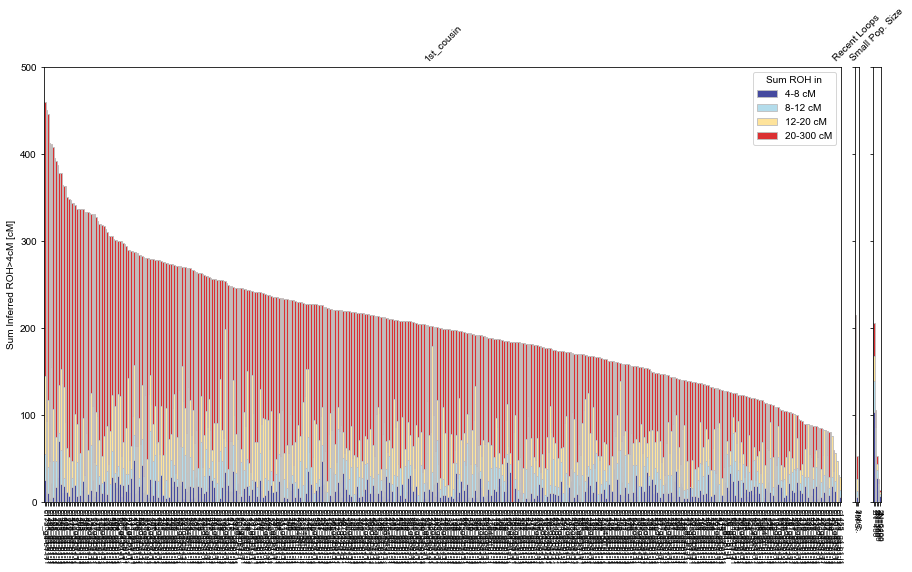

In [230]:
#plot_dfs =prepare_dfs_plot(df3, cms=[4,8,12,20])
plot_panel_row([df1[:]], ylim=[0,500],
               figsize=(15,8), r_title=45,
               savepath="", 
               leg_pos=-1)  # ./figures_test/1st_cousin_ped_sim.pdf

# Plot ROH Histograms for certain Length Categories

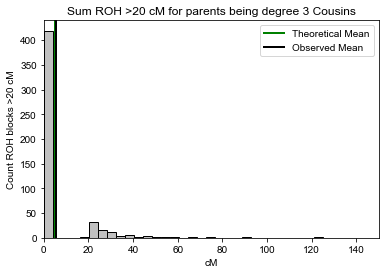

In [113]:
plot_distributions_roh(df3, cm1=20, cm2=0,
                       degree=3,
                       xlim=[0, 150],
                       lw = 2, c = "silver",
                       bins=np.linspace(0, 400, 100))

### Plot ultra long ROH Statistics

In [15]:
dfs = [df1, df2, df3]
labels = ["1st Cousin", "2nd Cousin", "3rd Cousin"]
colors = ["#fc8d59", "#ffffbf", "#91bfdb"]
colors = ["#d7191c", "#ffffbf", "#2b83ba"]
figsize=(7,7)
cm1=4
cm2=20
ec="k"
lw=0.3

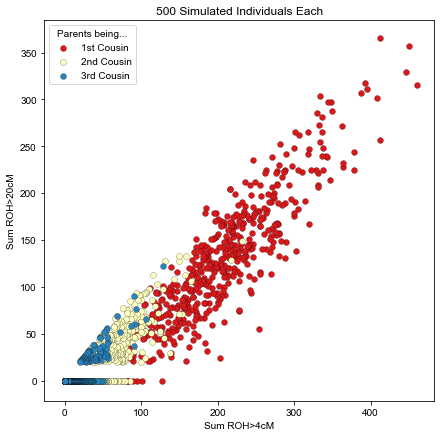

In [221]:
plot_scatter_roh([df1, df2, df3],
                cm1=4, cm2=20)

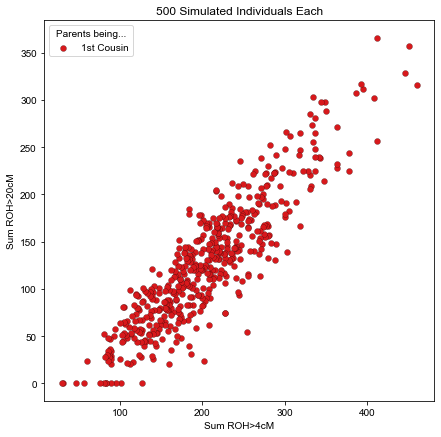

In [17]:
plot_scatter_roh([df1], cm1=4, cm2=20)

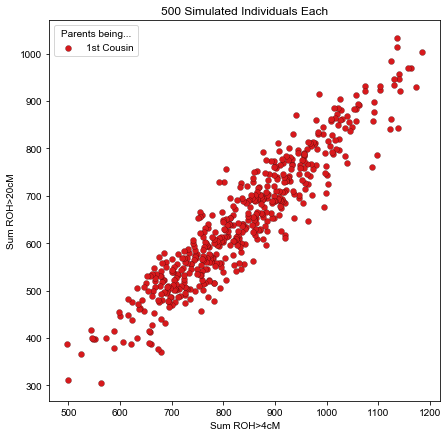

In [216]:
plot_scatter_roh([df0], cm1=4, cm2=20)

In [15]:
give_roh_df_stats([df1,df2,df3,df4,df5], 
                  cm1=20, cutoff=0)

Sum ROH>20 > 0
1st_cousin
488 / 500
2nd_cousin
259 / 500
3rd_cousin
76 / 500
4th_cousin
17 / 500
5th_cousin
3 / 500


### Plot first / second / third cousins

In [21]:
df_samples = [df.sample(n=30).sort_values(by="sum_roh>4", ascending=False) 
              for df in [df1,df2,df3]]

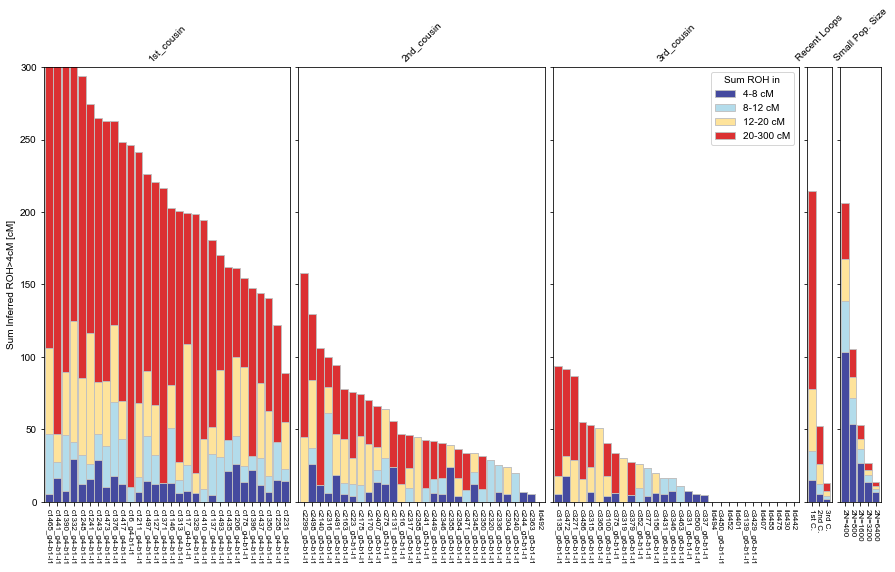

In [22]:
plot_panel_row(df_samples, ylim=[0,300],
               figsize=(15,8), r_title=45,
               savepath="", 
               leg_pos=-1)

In [9]:
df_samples = [df.sample(n=40).sort_values(by="sum_roh>4", ascending=False) 
                  for df in [df1, df2, df3, df4, df5]]

Saved figure to ./figures/pedsim/roh_distribution.pdf


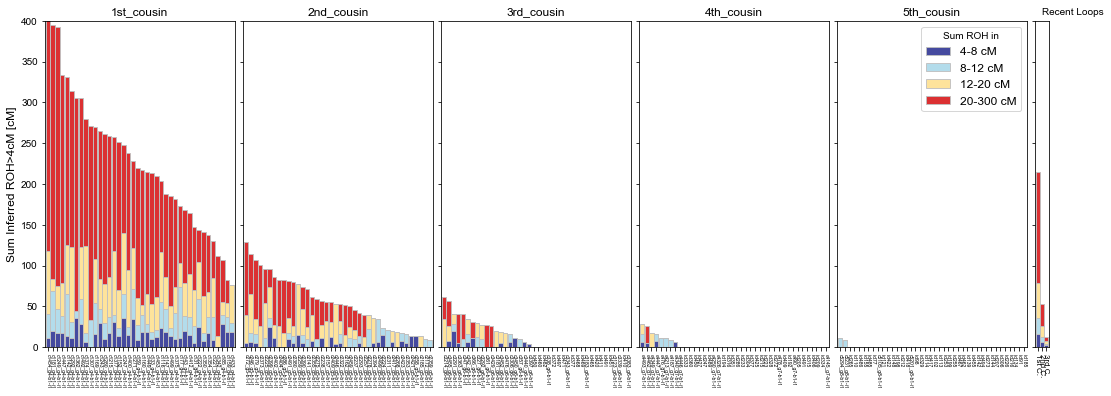

In [10]:
plot_panel_row(df_samples, ylim=[0,400],
               figsize=(18,6), r_title=0, ha_title="center",
               fs_t=12, fs_x=5, fs_y=12, fs_l=12,
               leg_pos=-1, degrees=[1, 2, 3], Ns=[],
               savepath="./figures/pedsim/roh_distribution.pdf")

# Make cumulative Sum plots for ROH>20
Requires that df1, df2 and df3 are loaded

Saved figure to ./figures/pedsim/cum_sums.pdf


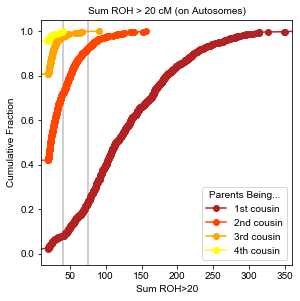

In [31]:
plot_cum_fracs(dfs = [df1, df2, df3, df4], figsize = (4.5,4.5),
               cm_min = 20,
               labels = ["1st cousin", "2nd cousin", "3rd cousin", "4th cousin"],
               colors = ["firebrick", "orangered", "orange", "yellow"],
               fs = 10, ms = 6, xlim = [10,360], vlines = [40, 75],
               savepath="./figures/pedsim/cum_sums.pdf")

In [10]:
df_t = create_summary_df(dfs=[df1, df2, df3, df4, df5], n=1000)
df_t

,labels,individuals,4-8 cM,8-12 cM,12-20 cM,>20 cM
0,1st_cousin,1000,913,848,939,977
1,2nd_cousin,1000,625,476,557,571
2,3rd_cousin,1000,289,172,227,142
3,4th_cousin,1000,107,68,65,23
4,5th_cousin,1000,23,12,20,2


In [20]:
print(df_t.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
     labels &  individuals &  4-8 cM &  8-12 cM &  12-20 cM &  >20 cM \\
\midrule
 1st\_cousin &         1000 &     913 &      848 &       939 &     977 \\
 2nd\_cousin &         1000 &     625 &      476 &       557 &     571 \\
 3rd\_cousin &         1000 &     289 &      172 &       227 &     142 \\
 4th\_cousin &         1000 &     107 &       68 &        65 &      23 \\
 5th\_cousin &         1000 &      23 &       12 &        20 &       2 \\
\bottomrule
\end{tabular}



### Creat cutoffs 

In [18]:
df_t2 = create_cutoffs_df(dfs=[df1, df2, df3, df4, df5], n=0, cutoffs=[50,100])
df_t2

,labels,sum(ROH >20 cM) >50,sum(ROH >20 cM) >100
0,1st_cousin,883,602
1,2nd_cousin,201,27
2,3rd_cousin,8,0
3,4th_cousin,0,0
4,5th_cousin,1,0


In [16]:
print(df_t2.to_latex(index=False)

\begin{tabular}{lrrrr}
\toprule
     labels &  individuals &  sum(ROH >20 cM) >0 &  sum(ROH >20 cM) >50 &  sum(ROH >20 cM) >100 \\
\midrule
 1st\_cousin &         1000 &                 977 &                  883 &                   602 \\
 2nd\_cousin &         1000 &                 571 &                  201 &                    27 \\
 3rd\_cousin &         1000 &                 142 &                    8 &                     0 \\
 4th\_cousin &         1000 &                  23 &                    0 &                     0 \\
 5th\_cousin &         1000 &                   2 &                    1 &                     0 \\
\bottomrule
\end{tabular}



### Area 51

In [110]:
df_emp = pd.read_csv("./Empirical/roh_all_inds.csv", sep="\t")
df_anc = df_emp[df_emp["age"]>0]
df_mod = df_emp[df_emp["age"]==0]

In [ ]:
give_roh_df_stats([df1, df2, df3, df_anc, df_mod], 
                  cutoff=75)

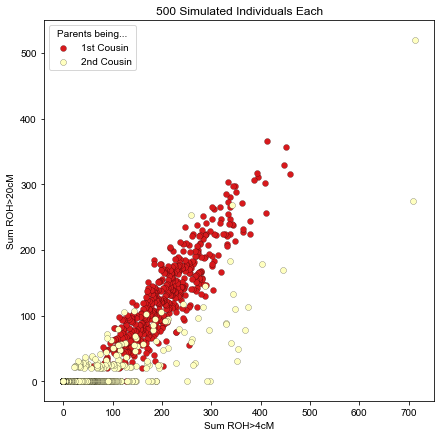

In [229]:
labels =["1st cousins", "Ancient Individuals"]
plot_scatter_roh([df1, df_anc], cm1=4, cm2=20)

In [25]:
df_anc[df_anc["pop"].str.contains("San_Nicolas")]

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,...,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt,color,region
132,SN-44.SG,E_San_Nicolas.SG,66.042196,708.805537,59,538.247216,29,457.817296,21,274.233502,...,33.264278,-119.539,5337.0,ScheibScience2018,E_San_Nicolas.SG,3.097140,1111229,1,silver,Pacific NW
133,SN-13.SG,L_San_Nicolas.SG,59.943003,444.706471,35,368.295167,20,321.720867,15,170.131979,...,33.264278,-119.539,811.0,ScheibScience2018,L_San_Nicolas.SG,0.580568,509837,1,silver,Pacific NW
143,SN-11.SG,L_San_Nicolas.SG,36.899203,329.975728,32,228.405825,14,169.441214,8,87.454705,...,33.264278,-119.539,1100.0,ScheibScience2018,L_San_Nicolas.SG,1.850441,975879,1,silver,Pacific NW


In [ ]:
df_anc = df_anc[df_anc["age"]==0]

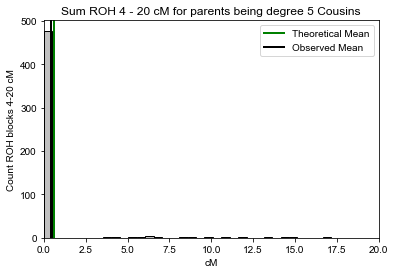

In [39]:
plot_distributions_roh(df5, cm1=4, cm2=20,
                       degree=5,
                       xlim=[0, 20],
                       lw = 2, c = "silver",
                       bins=np.linspace(0, 50, 100))